# Section-0: Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import IPython.core.display as di
from IPython.core.interactiveshell import InteractiveShell

In [2]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid.anchored_artists import AnchoredDrawingArea
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud, STOPWORDS

import geojson

import numpy as np

C:\Users\annefou\AppData\Local\Continuum\anaconda3\envs\RSE\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000) 

In [4]:
# This text is used to hide the code cell when exported in html
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [5]:
get_ipython().magic('matplotlib inline')  # Activate that line to use in Jupyter 
matplotlib.rcParams['figure.figsize'] = (15.0, 20.0)

In [6]:
def get_country_flag(name):
    path = "./2018/nordics/images/flags/{}.png".format(name)
    im = plt.imread(path)
    return im
# Locations (lon, lat) where we will plot country flags on the map
flags = { "Norway": (8.7, 66.25), "Sweden": (18.30, 66.23), "Denmark": (5.50, 55.8), 
         "Iceland": (-17.11, 67.50), "Finland": (25.42, 62.5)}  

# Nordic Countries facts

Nordic countries cover a large geographical area while its total population is less than 30 millions. Nordic Scientific collaboration is strongly supported by several funding entities ([NeIC](https://neic.no/), [NordForsk](https://www.nordforsk.org), etc.) and gives Nordic countries much more international visibility. It is critical in Iceland where the total population is less than 500 000 inhabitants.

In [7]:
population=pd.Series(data=[5511300.0, 5282220.0, 341280, 5769600, 10067740], index=["Finland", "Norway", "Iceland", "Denmark", "Sweden"])
print(population)
print("{:0.2f} millions inhabitants in all Nordic countries".format(population.sum()/1000000.))

Finland     5511300.0
Norway      5282220.0
Iceland      341280.0
Denmark     5769600.0
Sweden     10067740.0
dtype: float64
26.97 millions inhabitants in all Nordic countries


# Load dataset

In [8]:
df =  pd.read_csv('./2018/nordics/data/public_data.csv')

# Section 1. Social demographics

In this section, we determine some information about the demographics of the respondents: country of work, gender and age. 

In [9]:
print('The total number of particants in this study: {}'.format(len(df)))

The total number of particants in this study: 104


### Number of participants per Nordic country

In [10]:
df_sub = df['What country are you working in'].dropna()
# create new rows when multiples answers
v_to_count = df_sub.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()

In [11]:
print(v_to_count)

Norway     45
Sweden     44
Finland     8
Denmark     5
Iceland     3
dtype: int64


### Percentage of participants in each Nordic country

In [12]:
perc_to_count=v_to_count/v_to_count.values.sum()*100.
print(perc_to_count)

Norway     42.857143
Sweden     41.904762
Finland     7.619048
Denmark     4.761905
Iceland     2.857143
dtype: float64


### Geographical map showing 
* **the number of participants per Nordic country**
* **cities with core team members**

C:\Users\annefou\AppData\Local\Continuum\anaconda3\envs\RSE\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\annefou\AppData\Local\Continuum\anaconda3\envs\RSE\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


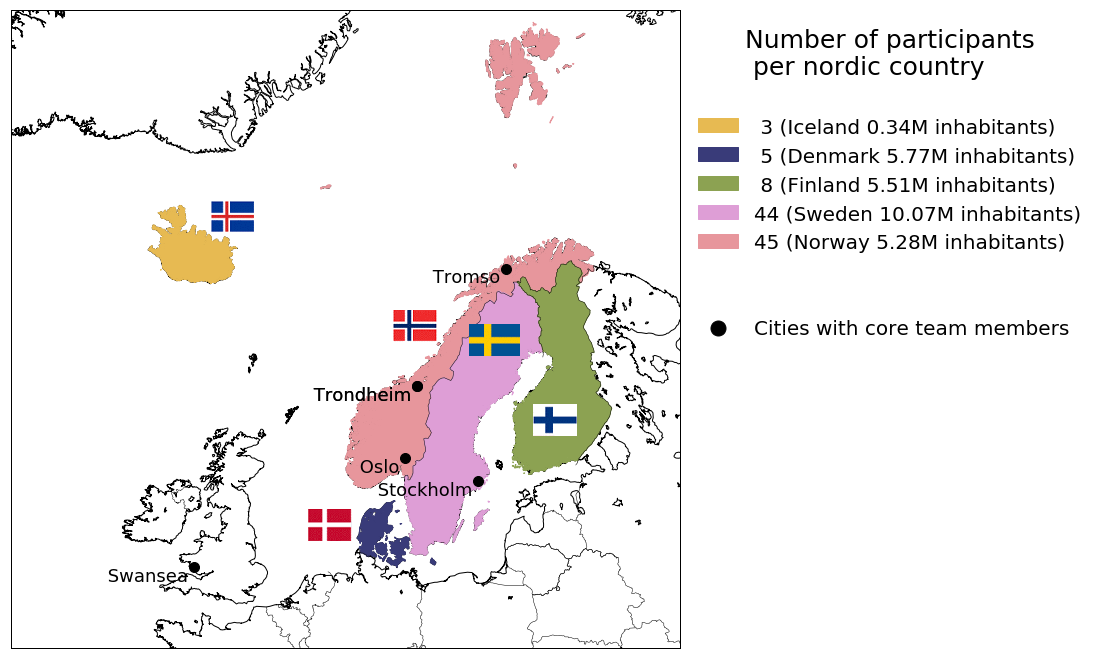

In [13]:
fig     = plt.figure(figsize=[12,15])
ax      = fig.add_subplot(111)

# Choose projection (centered on the Nordic countries...)
map = Basemap(llcrnrlon=-13.0,urcrnrlon=58.,llcrnrlat=44.,urcrnrlat=80.,
              resolution='i', projection='lcc', lat_1=55., lon_0=25.)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='#ffe2ab', zorder=0, ax=ax)

map.drawcoastlines()

# Read shapefile containing countries so we can fill each Nordic country with a different color
map.readshapefile('2018/nordics/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries', 'ne_10m_admin_0_countries', 
                  drawbounds = False)
patches   = []

color_values = []

country_col=pd.concat([v_to_count.rename("Count"), population.rename("Population")], sort=True,axis=1)
# Assign a color to each country
country_col['color']=[0.0, 0.25, 0.5, 0.75, 1]

for i, info, shape in zip(range(len(map.ne_10m_admin_0_countries_info)),map.ne_10m_admin_0_countries_info, map.ne_10m_admin_0_countries):
        if info['ADMIN']== "Norway" or info['ADMIN']== "Sweden" or info['ADMIN']== "Iceland" or info['ADMIN']== "Finland"  or info['ADMIN']== "Denmark" :
            patches.append( Polygon(np.array(shape), True) )
            color_values.append(country_col.at[info["ADMIN"],'color'])

col = PatchCollection(patches, linewidths=1., zorder=2, color= plt.cm.tab20b(np.array(color_values)))

ax.add_collection(col)

# Add country boundaries
map.drawcountries()

# Read geojson file with Nordic core team information (cities where they work, names, institutions, etc.)
json_file = open("./2018/nordics/data/core-teamNRSE.geojson")
json_data = geojson.load(json_file)

# Create lists lats, lon and labels for the core team
core_team_lats = []
core_team_lons = []
core_team_labels = []
for i in range(len(json_data.features)):
    core_team_lons.append(json_data.features[i]['geometry']['coordinates'][0])
    core_team_lats.append(json_data.features[i]['geometry']['coordinates'][1])
    core_team_labels.append(" " + json_data.features[i]['properties']['city'] + " ")
    
# Reprojection of locations in our map
x,y = map(core_team_lons,core_team_lats)
# plot location of each member of the Nordic RSE core team
core_team_plot = plt.scatter(x,y,s=100, marker='o', c='black', zorder=2)

# Add city names
for i in range(len(json_data.features)):
    ax.annotate(core_team_labels[i], (x[i], y[i]), fontsize=18,  horizontalalignment='right', verticalalignment='top', color="black")

# Create legend for both countries and core-team information

# Step-1: Create legend for countries with corresponding labels
legend_elements = []

# labels and colors depend on the number of inhabitants
for index,elem in country_col.sort_values(by="Count").iterrows():
    legend_elements.append(Patch(facecolor=plt.cm.tab20b(elem["color"]), edgecolor=plt.cm.tab20b(elem["color"]),
                         label="{:2.0f} ({} {:0.2f}M inhabitants)".format(elem["Count"], index,elem["Population"]/1000000.)))

    
legend=ax.legend(handles=legend_elements, 
          title="Number of participants\n per nordic country\n",
          loc="upper left",
          bbox_to_anchor=(1, 0, 0.4, 1.0), fontsize=20, frameon=False)

legend.get_title().set_fontsize(25)

# Step-2: create legend for core team

legend_elements_core_team = [Line2D([], [], color='black', marker='o', linestyle='None', 
                             markersize=15, label='Cities with core team members')]

legend_core_team = ax.legend(handles=legend_elements_core_team, 
          loc="center left",
          bbox_to_anchor=(1, 0, 0.4, 1.0), fontsize=20, frameon=False)

legend_core_team.get_title().set_fontsize(25)

plt.gca().add_artist(legend)

# Add flags in each Nordic countries. 

for flag in flags:
    im = OffsetImage(get_country_flag(flag), zoom=0.8)
    im.image.axes = ax
    # Reprojection of locations in our map
    x,y = map(flags[flag][0], flags[flag][1])
    ab = AnnotationBbox(im, [x,y],
                        xycoords='data',
                        frameon=False)

    ax.add_artist(ab)
    
ax.set(aspect="equal")

fig.savefig('./2018/nordics/outputs/who_we_are.png', bbox_inches='tight')

## Country of work

The data contains nordic respondents only. The maximum number of answers are in Norway and Sweden. However if we compare the ratio between the number of answers and the number of inhabitants in the corresponding country then Iceland comes first, followed by Norway and Sweden and Denmark is last. We clearly failed to trigger enough interests both in Finland and Denmark.  Currently, the majority of the Nordic RSE core team lives in Norway (4 over 6) which shows the **importance of having local contact points**. To establish a network for Nordic RSE including Denmark and Finland, we would need to find local contact points in each Nordic country, able to relay our actions at a national level.

In [14]:
perc_to_pop=population/population.values.sum()*100
val = v_to_count.sort_index() / population.sort_index()
val = val / val.mean()

In [15]:
country_info= pd.concat([country_col,perc_to_count.rename("Percentage RSE"), perc_to_pop.rename("% Nordic population"),
                         val.rename("scaled answer ratio")], sort=True,axis=1)

country_info["scaled answer ratio"]=country_info["scaled answer ratio"]/country_info["scaled answer ratio"].max()
print(country_info)

         Count  Population  color  Percentage RSE  % Nordic population  \
Denmark      5   5769600.0   0.00        4.761905            21.390961   
Finland      8   5511300.0   0.25        7.619048            20.433306   
Iceland      3    341280.0   0.50        2.857143             1.265306   
Norway      45   5282220.0   0.75       42.857143            19.583986   
Sweden      44  10067740.0   1.00       41.904762            37.326441   

         scaled answer ratio  
Denmark             0.098586  
Finland             0.165130  
Iceland             1.000000  
Norway              0.969138  
Sweden              0.497176  


### In which country did we get the most answers compared to its population?

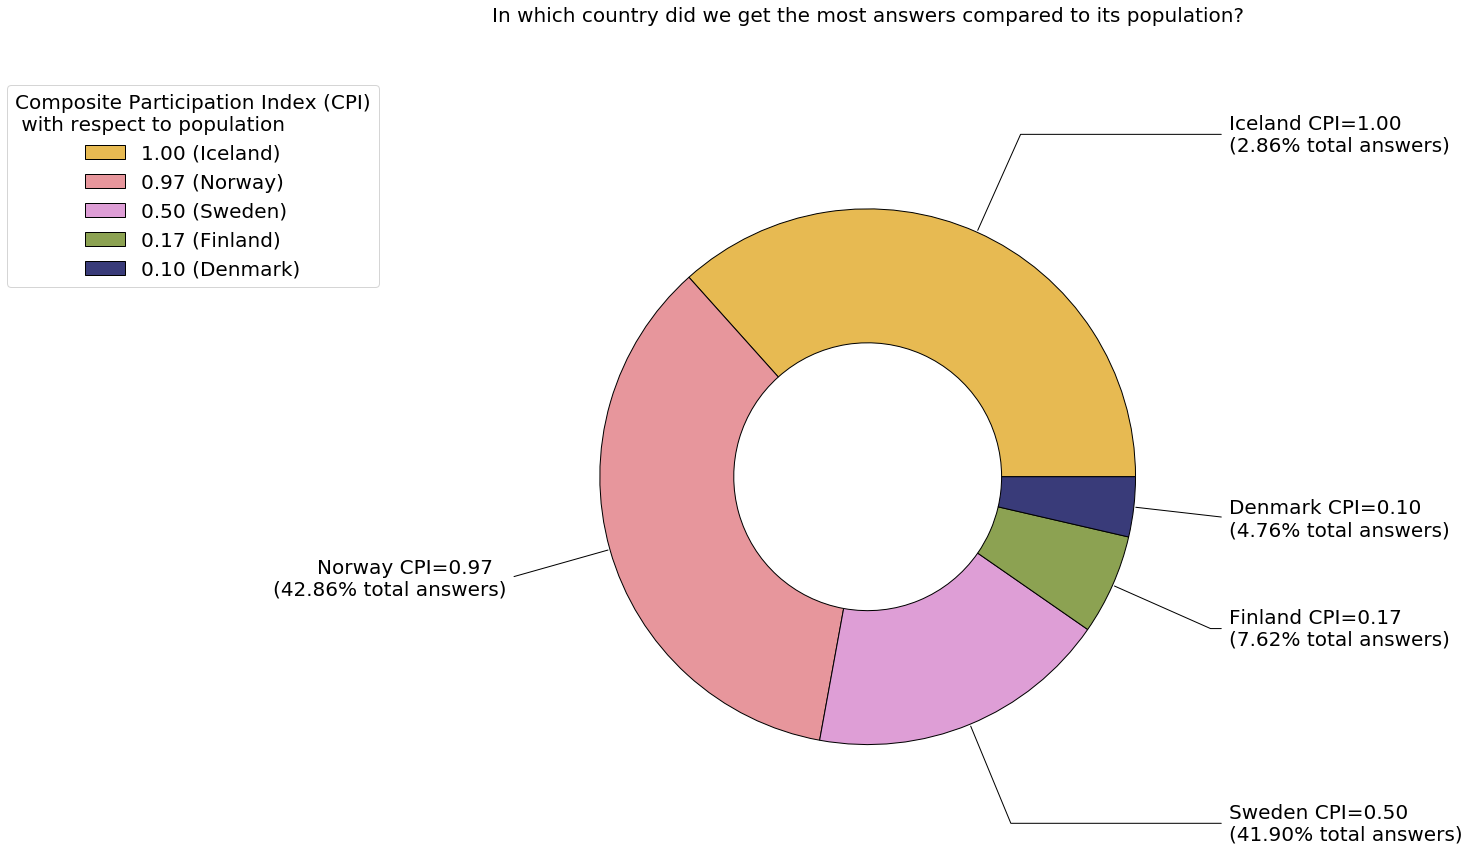

In [16]:
fig     = plt.figure(figsize=[12,20])
ax      = fig.add_subplot(111)
cmap = plt.get_cmap("gist_ncar")
color = plt.cm.tab20b(country_info.sort_values(["scaled answer ratio"], ascending=0)["color"])    
wedges, texts= ax.pie(country_info.sort_values(["scaled answer ratio"], ascending=0)["scaled answer ratio"], 
                      radius=1, colors = color, 
                      wedgeprops=dict(width=0.5, edgecolor='black'))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

labels = [f"{i:} CPI={j:0.2f}  \n({k:0.2f}% total answers)" 
          for i,j,k in zip(country_info.sort_values(["scaled answer ratio"], ascending=0).index.tolist(), 
                           country_info.sort_values(["scaled answer ratio"], ascending=0)["scaled answer ratio"],
                           country_info.sort_values(["scaled answer ratio"], ascending=0)["Percentage RSE"] 
                         )]


for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    kw["bbox"].update(dict(boxstyle="round", fc="none", ec="none"))
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 fontsize=20, horizontalalignment=horizontalalignment, **kw)

    
labels = [f"{j:0.2f} ({i:})" for i,j in zip(country_info.sort_values(["scaled answer ratio"], ascending=0).index.tolist(),
                                            country_info.sort_values(["scaled answer ratio"], ascending=0)["scaled answer ratio"])]

legend=ax.legend(wedges, labels,
          title="Composite Participation Index (CPI)\n with respect to population",
          loc="upper left",
          bbox_to_anchor=(-0.8, 1.1), fontsize=20)
legend.get_title().set_fontsize(20)
ax.set(aspect="equal")

plt.text(0.5, 1.18, 'In which country did we get the most answers compared to its population?',
         horizontalalignment='center',
         fontsize=20,
         transform = ax.transAxes)
fig.savefig('./2018/nordics/outputs/countries_compared_to_population.png', bbox_inches='tight')

## Gender


Their is a clear gender imbalance in the RSE community in the Nordic countries. It is predominately *male* (86%). Only 14% of the participants describe their gender as *female*. 

The [European Institute for Gender Equality](http://eige.europa.eu) (EIGE) regularly monitors the [Gender Equality Index](http://eige.europa.eu/gender-equality-index) (GEI) and Nordic countries appear in the top 5 with a GEI in 2015 between 73 and 83 while the EU-28 average is 66.2. However, gender imbalance among RSE community is similar to what is observed elsewhere. 

 [The Nordic region – a step closer to gender balance in research?](http://norden.diva-portal.org/smash/get/diva2:702842/FULLTEXT01.pdf) paper highlights the fact that *Although women comprise the majority of the students who have completed a master’s degree and there is relative gender balance among those awarded a doctoral degree, academia does not have the proportion of women expected at the highest level, i.e. among professors. About 80 per cent
of professors in the Nordic countries are men.*


**Conclusion**: it is important to analyze and understand what has been tried in the Nordic countries and develop strategies to improve gender balance. [Dr Curt Rice](https://en.wikipedia.org/wiki/Curt_Rice) explains in [How can we improve the gender balance in academia?](https://www.nordforsk.org/en/news/how-can-we-improve-the-gender-balance-in-academia) that the current career structure in research has negative impact on women. The reasons for gender imbalance in the RSE community in the Nordic countries can be similar and highlights the importance to recognize Research Software Engineer career path.


## What is your gender?

Male      85.576923
Female    14.423077
Name: What is your gender?, dtype: float64


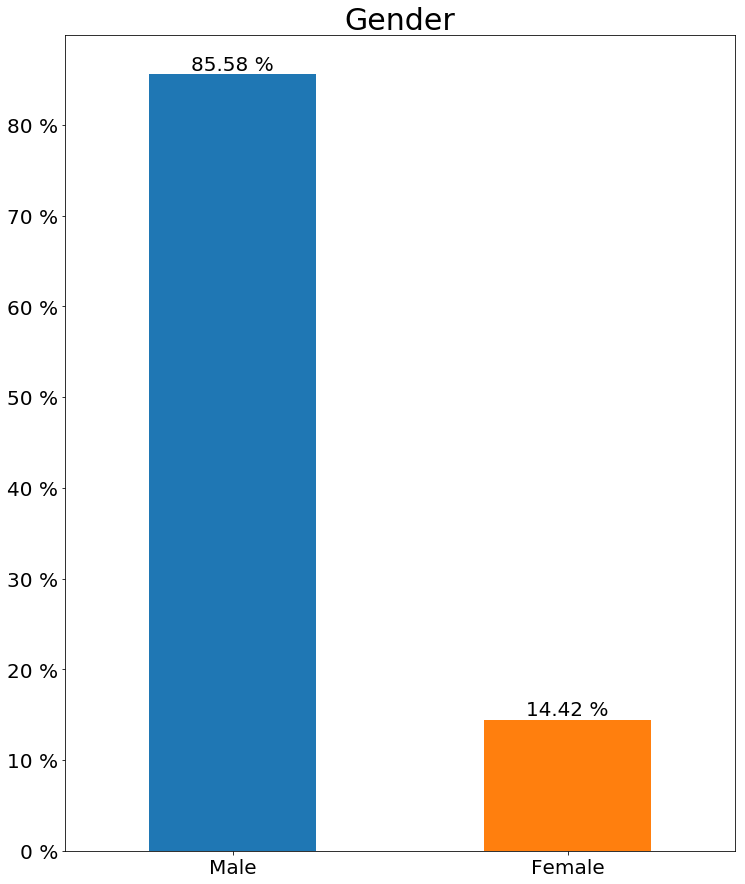

In [17]:
fig     = plt.figure(figsize=[12,15])
ax      = fig.add_subplot(111)
ax.set_title('Gender',fontsize= 30) # title of plot

perc_to_count=df['What is your gender?'].value_counts()/df['What is your gender?'].value_counts().sum()*100.
print(perc_to_count)
perc_to_count.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_gender = []
for i in range(0,101,10):
    labels_gender.append("{:} %".format(i))
    
ax.set_yticklabels(labels=labels_gender)
fig.savefig('./2018/nordics/outputs/gender.png', bbox_inches='tight')

### Comparison to other countries

* Read statistics from UK, ZAF, US, DE, CAN 

In [18]:
df_nl =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/nl/output/socio2.csv', index_col=0)
df_zaf =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/zaf/output/socio2.csv', index_col=0)
df_uk =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/uk/output/socio2.csv', index_col=0)
df_us =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/us/output/socio2.csv', index_col=0)
df_de =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/de/output/socio2.csv', index_col=0)
# remove NaN
df_nl= df_nl[:-1]
df_zaf= df_zaf[:-1]
df_uk= df_uk[:-1]
df_us= df_us[:-1]
df_de= df_de[:-1]

In [19]:
perc_to_count_us=df_us['socio2. Please select your gender']/df_us['socio2. Please select your gender'].sum()*100.
perc_to_count_nl=df_nl['socio2. Please select your gender']/df_nl['socio2. Please select your gender'].sum()*100.
perc_to_count_zaf=df_zaf['socio2. Please select your gender']/df_zaf['socio2. Please select your gender'].sum()*100.
perc_to_count_de=df_de['socio2. Please select your gender']/df_de['socio2. Please select your gender'].sum()*100.
perc_to_count_uk=df_uk['socio2. Please select your gender']/df_uk['socio2. Please select your gender'].sum()*100.
print("Gender (%) in US")
print(perc_to_count_us)
print("Gender (%) in NL")
print(perc_to_count_nl)
print("Gender (%) in ZAF")
print(perc_to_count_zaf)
print("Gender (%) in DE")
print(perc_to_count_de)
print("Gender (%) in UK")
print(perc_to_count_uk)

Gender (%) in US
Please select your gender
Male                 82.142857
Female               13.571429
Prefer not to say     4.285714
Name: socio2. Please select your gender, dtype: float64
Gender (%) in NL
Please select your gender
Male                 88.732394
Female                7.042254
Prefer not to say     4.225352
Name: socio2. Please select your gender, dtype: float64
Gender (%) in ZAF
Please select your gender
Male      92.307692
Female     7.692308
Name: socio2. Please select your gender, dtype: float64
Gender (%) in DE
Please select your gender
Male                 83.269962
Female               12.927757
Prefer not to say     3.802281
Name: socio2. Please select your gender, dtype: float64
Gender (%) in UK
Please select your gender
Male      84.331797
Female    15.207373
Other      0.460829
Name: socio2. Please select your gender, dtype: float64


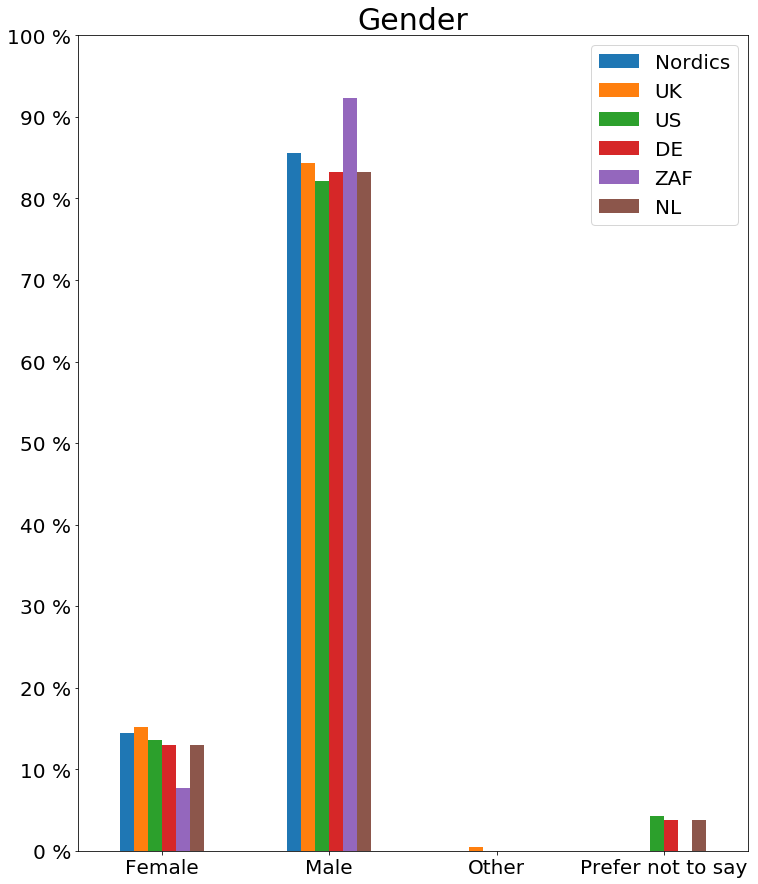

In [20]:
# Plot gender for each available country
fig     = plt.figure(figsize=[12,15])
ax      = fig.add_subplot(111)
ax.set_title('Gender',fontsize= 30) # title of plot

perc_to_count=df['What is your gender?'].value_counts()/df['What is your gender?'].value_counts().sum()*100.

# Plot.
pd.concat(
    [perc_to_count.rename('Nordics'), perc_to_count_uk.rename("UK"), 
     perc_to_count_us.rename("US"), perc_to_count_de.rename("DE"),
     perc_to_count_zaf.rename("ZAF"), perc_to_count_de.rename("NL")],
    axis=1, sort=True).plot.bar(ax=ax, rot=0, fontsize=20)

bpl, legend = ax.get_legend_handles_labels()
ax.legend(bpl, legend, loc='best', fontsize=20)
labels_gender = []
for i in range(0,101,10):
    labels_gender.append("{:} %".format(i))
ax.set_yticks(range(0,101,10))    
ax.set_yticklabels(labels=labels_gender)
fig.savefig('./2018/nordics/outputs/gender_comparison.png', bbox_inches='tight')

## Age

The majority of RSEs fall within the 25-44 years old age range, with the peak in the 25-34 years old age range. RSEs are younger than senior academics and less well distributed over age ranges than academics in general (see [HESA](https://www.hesa.ac.uk/news/26-02-2015/age-and-gender-of-staff) for details).

25 - 34         43.689320
35 - 44         37.864078
45 - 54         13.592233
55 - 64          2.912621
Less then 25     0.970874
65 or older      0.970874
Name: What is your age?, dtype: float64


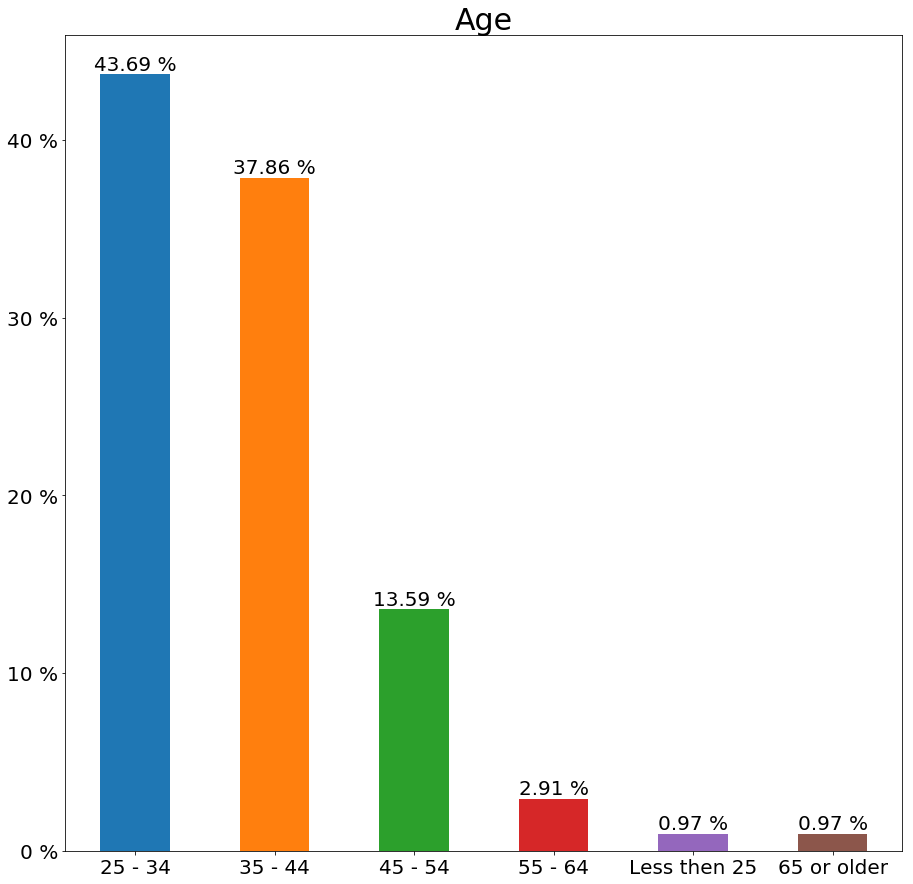

In [21]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Age',fontsize= 30) # title of plot

perc_to_age=df['What is your age?'].value_counts()/df['What is your age?'].value_counts().sum()*100.
print(perc_to_age)
perc_to_age.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_age = []
for i in range(0,101,10):
    labels_age.append("{:} %".format(i))

    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/age.png', bbox_inches='tight')

# Comparison to other countries
 * Read statistics from UK, ZAF, US, DE, CAN

In [22]:
df_nl =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/nl/output/socio3.csv', index_col=0)
df_zaf =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/zaf/output/socio3.csv', index_col=0)
df_uk =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/uk/output/socio3.csv', index_col=0)
df_us =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/us/output/socio3.csv', index_col=0)
df_de =  pd.read_csv('https://raw.githubusercontent.com/softwaresaved/international-survey/master/analysis/2017/de/output/socio3.csv', index_col=0)
df_nl.fillna(0, inplace = True)
df_zaf.fillna(0, inplace = True)
df_uk.fillna(0, inplace = True)
df_us.fillna(0, inplace = True)
df_de.fillna(0, inplace = True)
# remove NaN
df_zaf= df_zaf[:-1]
df_uk= df_uk[:-1]
df_us= df_us[:-1]

In [23]:
#rename columns for perc_to_age_no

perc_to_age_us=df_us['socio3. Please select your age']/df_us['socio3. Please select your age'].sum()*100.
perc_to_age_nl=df_nl['socio3. Please select your age']/df_nl['socio3. Please select your age'].sum()*100.
perc_to_age_zaf=df_zaf['socio3. Please select your age']/df_zaf['socio3. Please select your age'].sum()*100.
perc_to_age_de=df_de['socio3. Please select your age']/df_de['socio3. Please select your age'].sum()*100.
perc_to_age_uk=df_uk['socio3. Please select your age']/df_uk['socio3. Please select your age'].sum()*100.
# Make sure they have all the same numbers of categories!
perc_to_age_zaf['18 to 24 years'] = 0
perc_to_age_zaf['55 to 64 years'] = 0
perc_to_age_uk['Age 65 or older'] = 0

perc_to_age_us = perc_to_age_us.rename(index={ '18 to 24 years': 'Less then 25',  '25 to 34 years': '25 - 34', 
                                               '35 to 44 years': '35 - 44',  '45 to 54 years' : '45 - 54', 
                                               '55 to 64 years' : '55 - 64',  'Age 65 or older': '65 or older'})

perc_to_age_nl = perc_to_age_nl.rename(index={ '18 to 24 years': 'Less then 25',  '25 to 34 years': '25 - 34', 
                                               '35 to 44 years': '35 - 44',  '45 to 54 years' : '45 - 54', 
                                               '55 to 64 years' : '55 - 64',  'Age 65 or older': '65 or older'})

perc_to_age_zaf = perc_to_age_zaf.rename(index={ '18 to 24 years': 'Less then 25',  '25 to 34 years': '25 - 34', 
                                               '35 to 44 years': '35 - 44',  '45 to 54 years' : '45 - 54', 
                                               '55 to 64 years' : '55 - 64',  'Age 65 or older': '65 or older'})

perc_to_age_de = perc_to_age_de.rename(index={ '18 to 24 years': 'Less then 25',  '25 to 34 years': '25 - 34', 
                                               '35 to 44 years': '35 - 44',  '45 to 54 years' : '45 - 54', 
                                               '55 to 64 years' : '55 - 64',  'Age 65 or older': '65 or older'})

perc_to_age_uk = perc_to_age_uk.rename(index={ '18 to 24 years': 'Less then 25',  '25 to 34 years': '25 - 34', 
                                               '35 to 44 years': '35 - 44',  '45 to 54 years' : '45 - 54', 
                                               '55 to 64 years' : '55 - 64',  'Age 65 or older': '65 or older'})
print("Age (%) in NO")
print(perc_to_age)
print("Age (%) in US")
print(perc_to_age_us)
print("Age (%) in NL")
print(perc_to_age_nl)
print("Age (%) in ZAF")
print(perc_to_age_zaf)
print("Age (%) in DE")
print(perc_to_age_de)
print("Age (%) in UK")
print(perc_to_age_uk)


Age (%) in NO
25 - 34         43.689320
35 - 44         37.864078
45 - 54         13.592233
55 - 64          2.912621
Less then 25     0.970874
65 or older      0.970874
Name: What is your age?, dtype: float64
Age (%) in US
Please select your age
Less then 25     1.428571
25 - 34         37.857143
35 - 44         31.428571
45 - 54         20.000000
55 - 64          8.571429
65 or older      0.714286
Name: socio3. Please select your age, dtype: float64
Age (%) in NL
Please select your age
Less then 25     0.000000
25 - 34         42.253521
35 - 44         42.253521
45 - 54         11.267606
55 - 64          4.225352
65 or older      0.000000
Name: socio3. Please select your age, dtype: float64
Age (%) in ZAF
Please select your age
25 - 34         38.461538
35 - 44         38.461538
45 - 54         15.384615
65 or older      7.692308
Less then 25     0.000000
55 - 64          0.000000
Name: socio3. Please select your age, dtype: float64
Age (%) in DE
Please select your age
Less then 25  

In [24]:
print(pd.concat(
    [perc_to_age.rename('Nordics'), perc_to_age_uk.rename("UK"), 
     perc_to_age_us.rename("US"), perc_to_age_de.rename("DE"),
     perc_to_age_zaf.rename("ZAF"), perc_to_age_de.rename("NL")],
    axis=1, sort=True))

                Nordics         UK         US         DE        ZAF         NL
25 - 34       43.689320  35.454545  37.857143  45.038168  38.461538  45.038168
35 - 44       37.864078  40.000000  31.428571  38.549618  38.461538  38.549618
45 - 54       13.592233  17.272727  20.000000   8.778626  15.384615   8.778626
55 - 64        2.912621   5.454545   8.571429   5.725191   0.000000   5.725191
65 or older    0.970874   0.000000   0.714286   0.000000   7.692308   0.000000
Less then 25   0.970874   1.818182   1.428571   1.908397   0.000000   1.908397


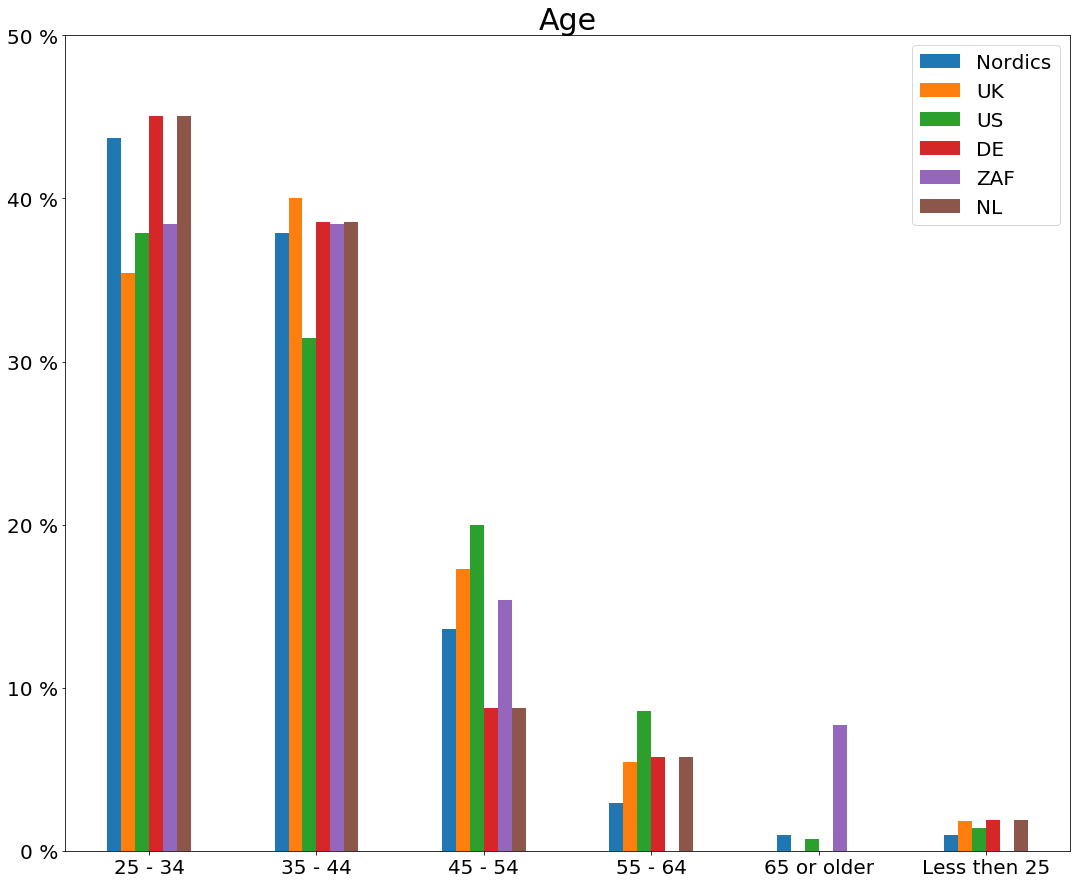

In [25]:
# Plot age for each available country
fig     = plt.figure(figsize=[18,15])
ax      = fig.add_subplot(111)
ax.set_title('Age',fontsize= 30) # title of plot

perc_to_age=df['What is your age?'].value_counts()/df['What is your age?'].value_counts().sum()*100.
# Plot.
pd.concat(
    [perc_to_age.rename('Nordics'), perc_to_age_uk.rename("UK"), 
     perc_to_age_us.rename("US"), perc_to_age_de.rename("DE"),
     perc_to_age_zaf.rename("ZAF"), perc_to_age_de.rename("NL")],
    axis=1, sort=True).plot.bar(ax=ax, rot=0, fontsize=20)

bpl, legend = ax.get_legend_handles_labels()
ax.legend(bpl, legend, loc='best', fontsize=20)
labels_age = []
for i in range(0,51,10):
    labels_age.append("{:} %".format(i))
ax.set_yticks(range(0,51,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/age_comparison.png', bbox_inches='tight')

# Section 2. Questions about coding

In this section we investigate the relationship between RSEs and the code they develop.

## Field of work

A majority of RSEs are working in "Biological, mathematical & physical sciences" (44.60%) but this is not necessarily representative of the RSEs in the Nordic countries. This plot mostly shows we reached RSEs in our own area of expertise (core-team field of work). To get more representative results, it is necessary to expand our network. It is crucial to define a strategy with local contact points spread over the Nordic countries.

Biological, mathematical & physical sciences         63
Engineering & technology                             38
Earth and environment                                11
Medicine, dentistry & health                         10
Humanities & language based studies & archaeology     4
Design, creative & performing arts                    3
Education                                             3
Social studies                                        2
Agriculture, forestry & veterinary science            2
Computer Science                                      1
Industrial Planning                                   1
environmental studies                                 1
Physics                                               1
dtype: int64
Biological, mathematical & physical sciences         45.000000
Engineering & technology                             27.142857
Earth and environment                                 7.857143
Medicine, dentistry & health                          7.142857
Humanit

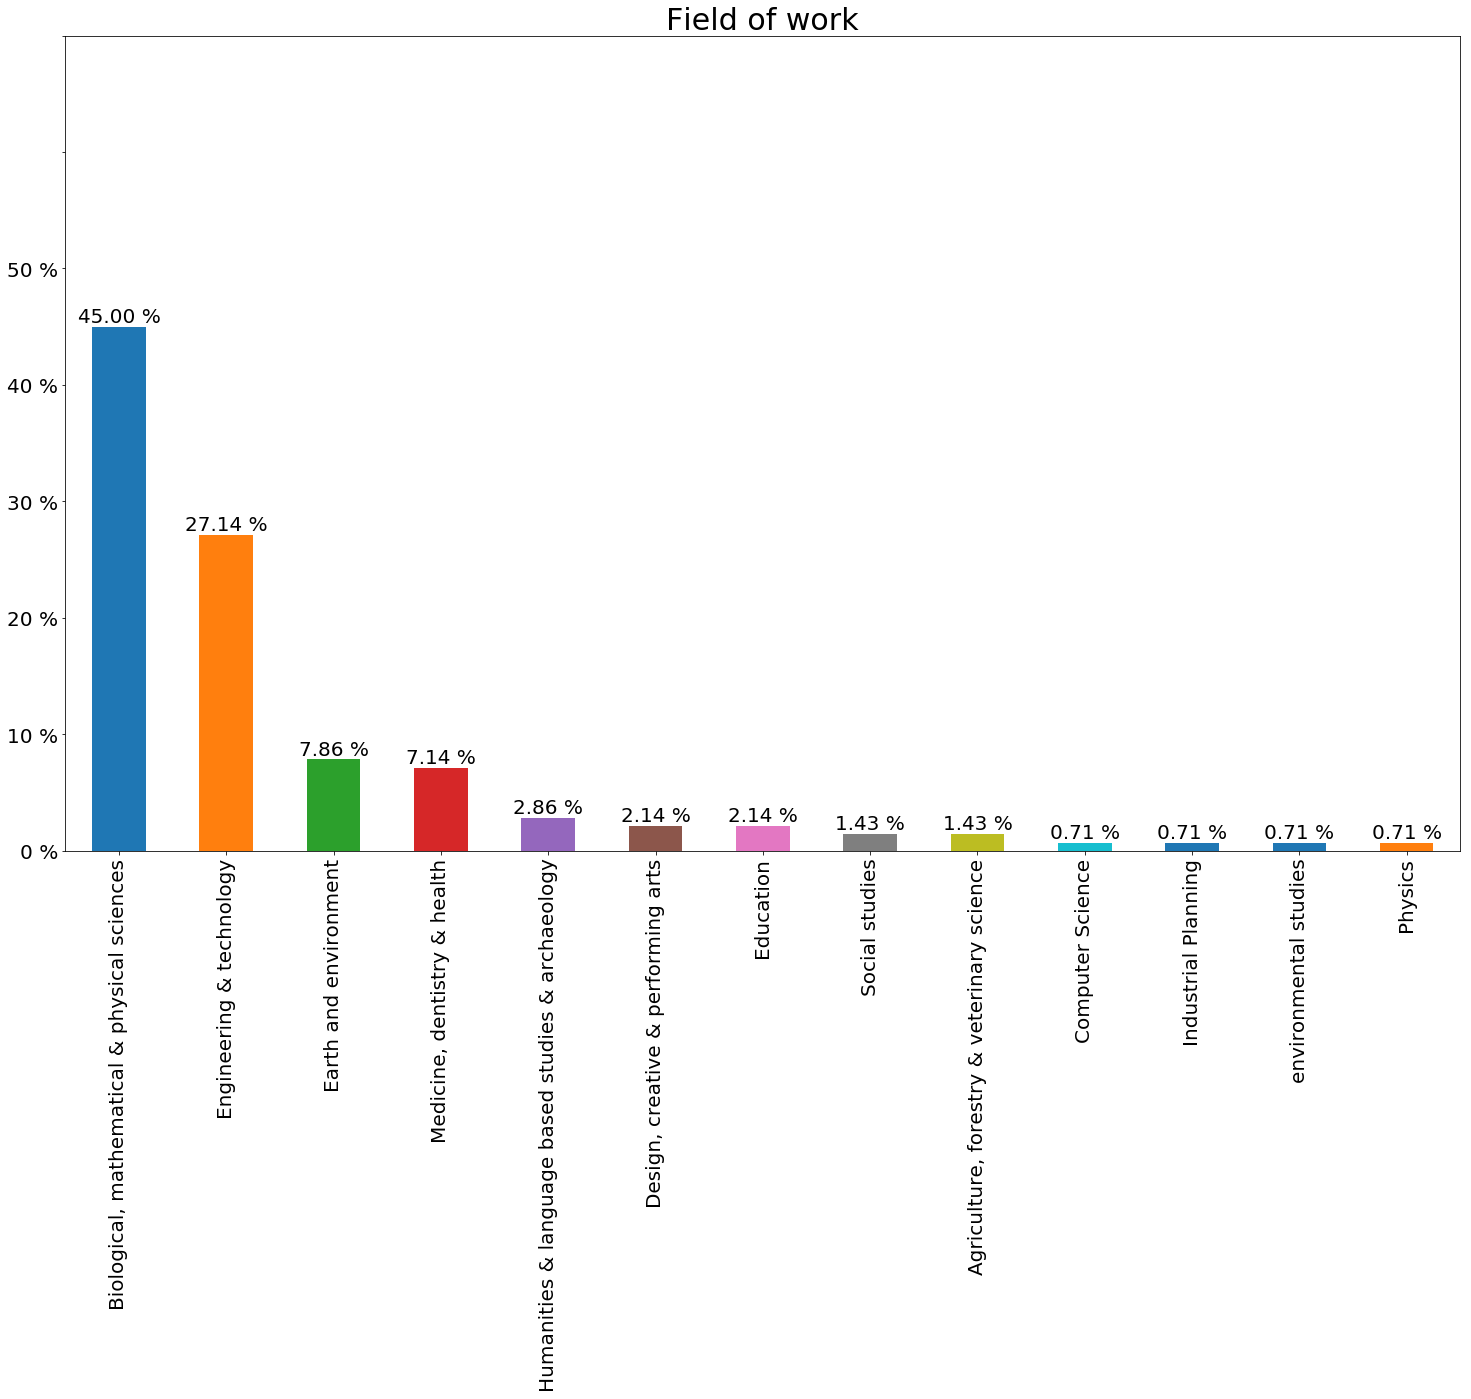

In [26]:
fig     = plt.figure(figsize=[25,15])
ax      = fig.add_subplot(111)
ax.set_title('Field of work',fontsize= 30) # title of plot

df_sub = df['Which of the following disciplines best applies to your work?'].dropna()
field_to_count = df_sub.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()
print(field_to_count)

perc_to_field=field_to_count/field_to_count.values.sum()*100
print(perc_to_field)

perc_to_field.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_field = []
for i in range(0,71,10):
    labels_field.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/field_of_work.png', bbox_inches='tight')


# Who uses software you develop?


* A majority of RSEs write code for themselves (39.01%) or collaborators (37.67%). The culture of sharing software within a large community (outside close collaborators) is not yet vastly adopted by RSEs. A question on whether RSEs in the Nordic countries know how to share software (github, zenodo, etc.) is missing.
* Other countries did not ask for the very same question so comparison is more difficult. 
  In other RSE countries, one had to give a number between 0 (mostly me) to 5 (mostly other people).

My collaborators/colleagues    88
Me                             85
Other people                   52
dtype: int64
My collaborators/colleagues    39.111111
Me                             37.777778
Other people                   23.111111
dtype: float64


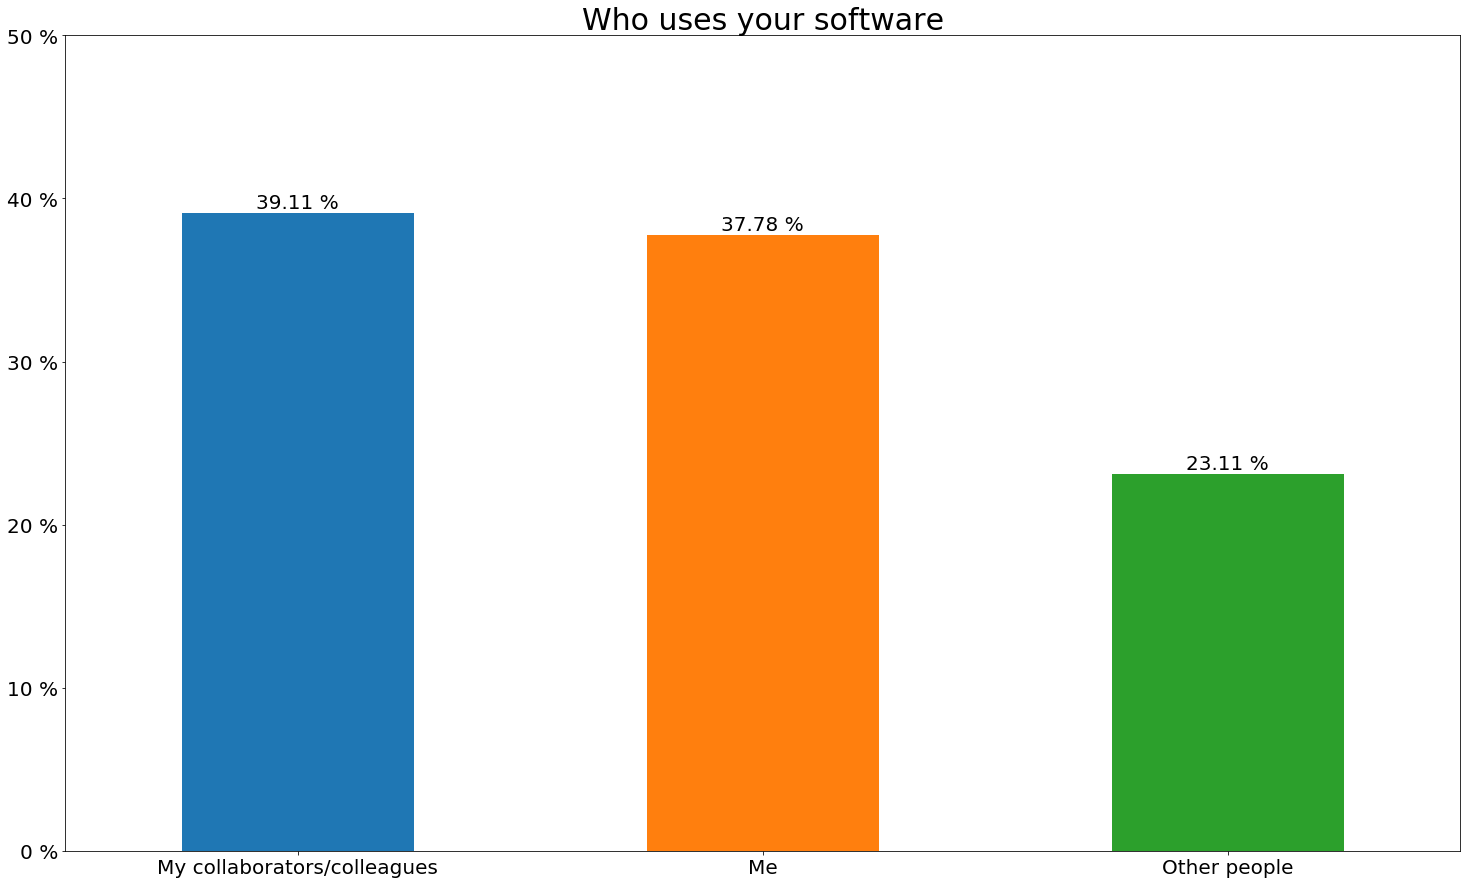

In [27]:
fig     = plt.figure(figsize=[25,15])
ax      = fig.add_subplot(111)
ax.set_title('Who uses your software',fontsize= 30) # title of plot

df_sub = df["If you develop software, who uses it?"].dropna()
dev_to_count = df_sub.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()
print(dev_to_count)
perc_to_dev=dev_to_count/dev_to_count.values.sum()*100
print(perc_to_dev)

perc_to_dev.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_field = []
for i in range(0,51,10):
    labels_field.append("{:} %".format(i))

ax.set_yticks(range(0,51,10))    
ax.set_yticklabels(labels=labels_field)
fig.savefig('./2018/nordics/outputs/sw_users.png', bbox_inches='tight')


# Section 3: Questions about employment

RSEs mainly work within universities: in total 66% work within a university. 51% of RSEs work in a university within an academic group (rather than in university within an IT service (8%) or HPC group (7%)). The other significant workplace for RSEs are the national laboratories where 16% of RSEs work.


### Which organisation do you work for?

In [28]:
# clean data (should be done another way...)
df_work = df["What institute/company do you work at"]
df_work.loc[df_work == "UiT - The Arctic University of Norway"] = "The Arctic University of Norway"
df_work.loc[df_work == "UiT The Arctic University of Norway"] = "The Arctic University of Norway"
df_work.loc[df_work == "University of Tromsø"] = "The Arctic University of Norway"

df_work.loc[df_work == "University of Oslo "] = "University of Oslo"
df_work.loc[df_work == "UiO"] = "University of Oslo"

df_work.loc[df_work == "NTNU, the Norwegian University of Science and Technology"] = "Norwegian University of Science and Technology"
df_work.loc[df_work == "NTNU"] = "Norwegian University of Science and Technology"

df_work.loc[df_work == "KTH Royal Institute of Technology"] = "Royal Institute of Technology"
df_work.loc[df_work == "KTH"] = "Royal Institute of Technology"
df_work.loc[df_work == "KTH Stockholm"] = "Royal Institute of Technology"
df_work.loc[df_work == "PDC"] = "Royal Institute of Technology"

df_work.loc[df_work == "University of Iceland "] = "University of Iceland"

df_work.loc[df_work == "U. of Southern Denmark (CP3-Origins)"] = "University of Southern Denmark"

df_work.loc[df_work == "Uppsala Universitet"] = "Uppsala university"

df_work.loc[df_work == "CICERO Center for International Climate Research"] = "Center for International Climate Research"



df_work.dropna().unique()

array(['University of Oslo',
       'Norwegian University of Science and Technology',
       'The Arctic University of Norway', 'Simula Research Laboratory',
       'The Norwegian Meteorological Institute',
       'National Bioinformatics Infrastructure Sweden / Uppsala University',
       'Royal Institute of Technology', 'Radiumhospitalet', 'NINA',
       'University of Copenhagen', 'Aalto University',
       'Uppsala University', 'KTH Stockholm, SciLifeLab',
       'University of Iceland', 'Gothenburg University',
       'Norwegian Veterinary Institute', 'SciLifeLab',
       'Niels Bohr Institute', 'Uppsala university', 'Uppsala University ',
       'Science for Life Laboratory',
       'Natural Resources Institute Finland', 'University of Bergen',
       'University of Helsinki', 'Norwegian Meteorological Institute',
       'Stockholm University', 'Karolinska Institutet',
       'Royal Institute of Technology Stockholm', 'Linköping University',
       'Linköping University ', 'self-

(-0.5, 1499.5, 1499.5, -0.5)

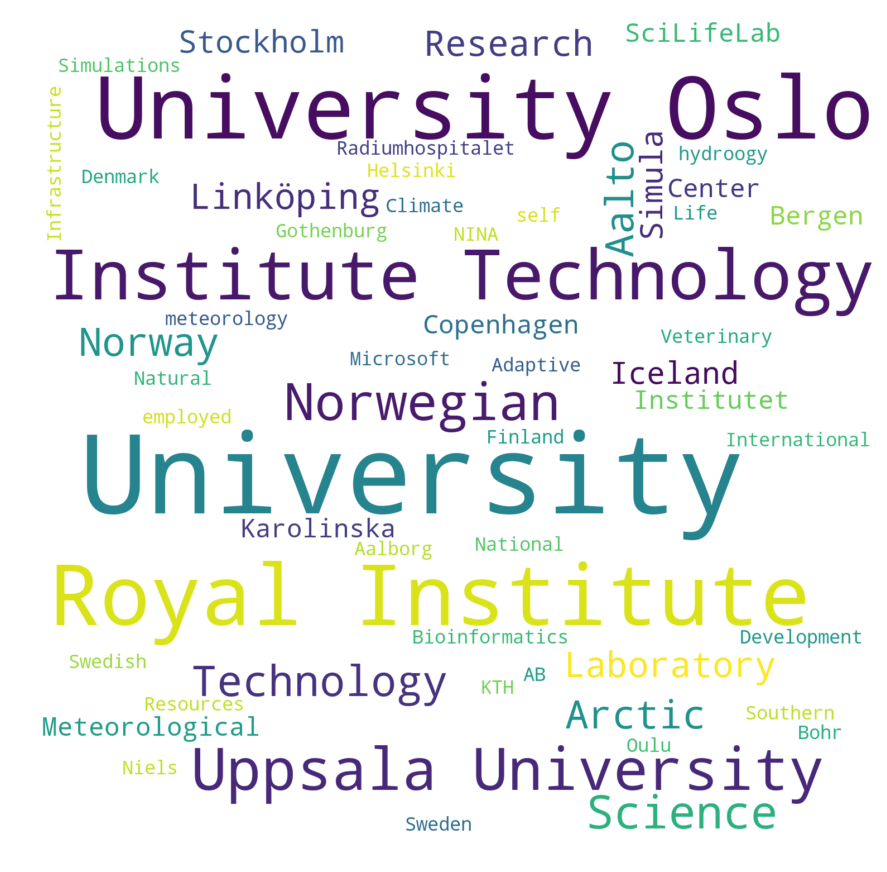

In [29]:
list_words = df_work.str.cat(sep=' ')
wc = WordCloud(background_color='white', width=1500, height=1500).generate(list_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [30]:
work_to_count = df_work.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()
print(work_to_count)

perc_to_work=work_to_count/work_to_count.values.sum()*100
print(perc_to_work)

University of Oslo                                                    18
Royal Institute of Technology                                         16
Uppsala University                                                     9
Norwegian University of Science and Technology                         6
The Arctic University of Norway                                        5
Aalto University                                                       5
Linköping University                                                   4
University of Iceland                                                  3
Simula Research Laboratory                                             3
Karolinska Institutet                                                  2
Uppsala university                                                     2
University of Bergen                                                   2
National Bioinformatics Infrastructure Sweden / Uppsala University     1
University of Oulu                                 

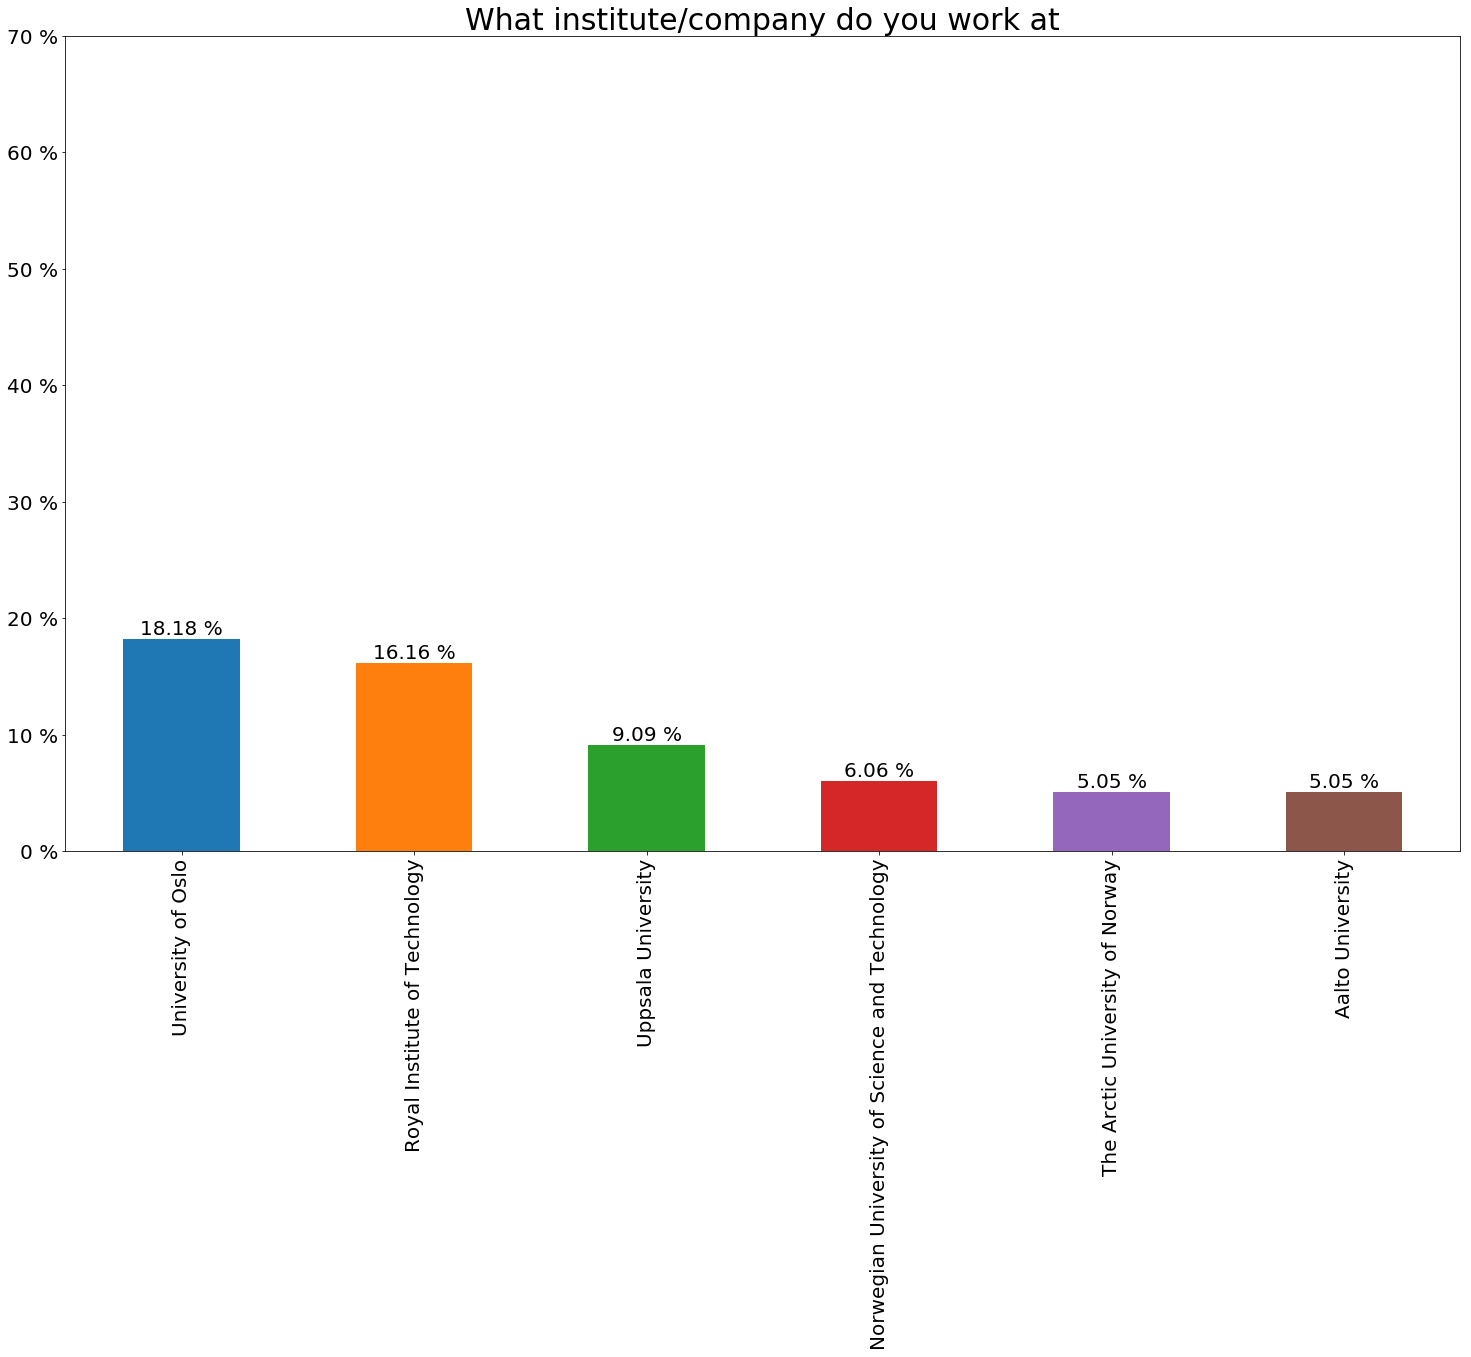

In [31]:
fig     = plt.figure(figsize=[25,15])
ax      = fig.add_subplot(111)
ax.set_title('What institute/company do you work at',fontsize= 30) # title of plot


perc_to_work = perc_to_work[perc_to_work>5]

perc_to_work.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_work = []

for i in range(0,71,10):
    labels_work.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_work)
fig.savefig('./2018/nordics/outputs/work_place.png', bbox_inches='tight')


# What is your role

I conduct research                                       84
I develop software for researchers                       60
I support researchers                                    36
I manage researchers or research projects                21
I teach                                                   1
I teach scientific computing and software development     1
I manage staff devloping software for researchers         1
dtype: int64
I conduct research                                       41.176471
I develop software for researchers                       29.411765
I support researchers                                    17.647059
I manage researchers or research projects                10.294118
I teach                                                   0.490196
I teach scientific computing and software development     0.490196
I manage staff devloping software for researchers         0.490196
dtype: float64


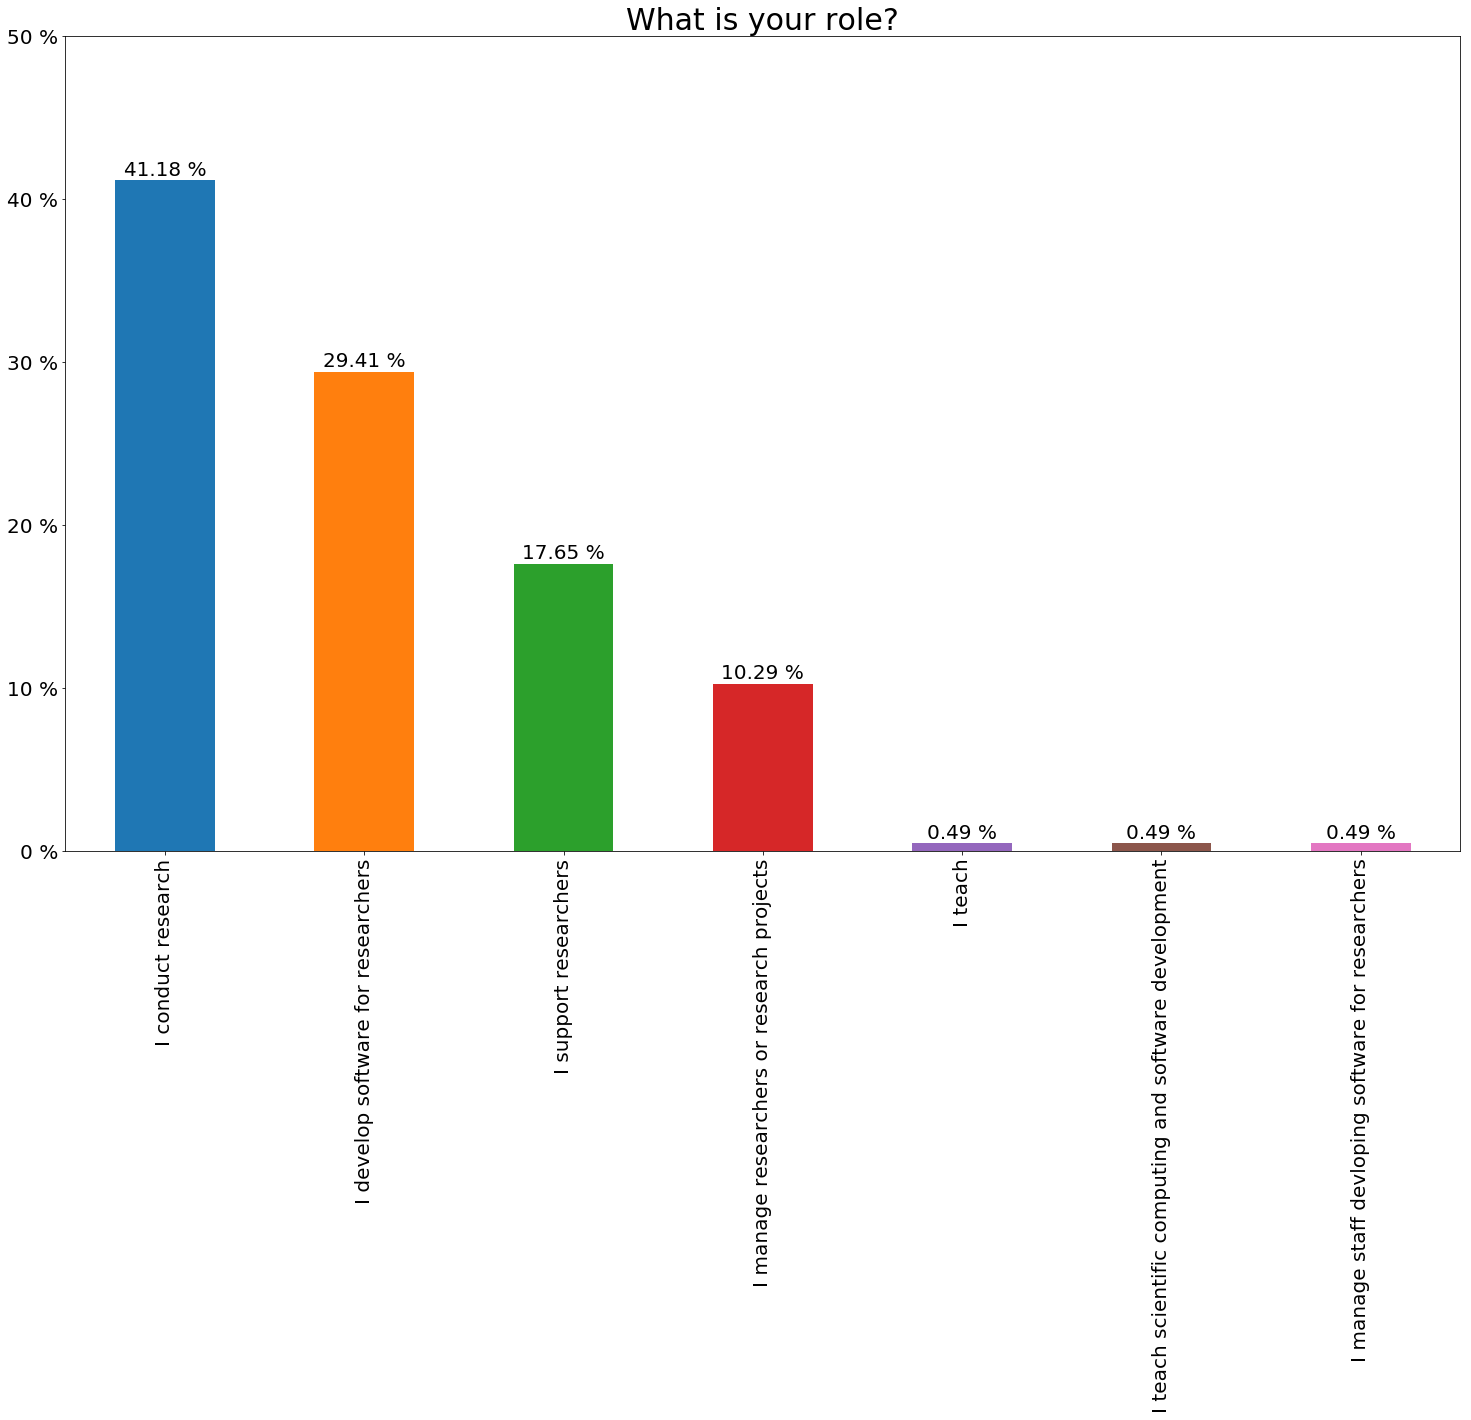

In [32]:
fig     = plt.figure(figsize=[25,15])
ax      = fig.add_subplot(111)
ax.set_title('What is your role?',fontsize= 30) # title of plot

df_sub = df['Which of the following roles apply to you?'].dropna()
role_to_count = df_sub.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()
print(role_to_count)
perc_to_role=role_to_count/role_to_count.values.sum()*100
print(perc_to_role)

perc_to_role.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_role = []
for i in range(0,51,10):
    labels_role.append("{:} %".format(i))

ax.set_yticks(range(0,51,10))    
ax.set_yticklabels(labels=labels_role)
fig.savefig('./2018/nordics/outputs/role.png', bbox_inches='tight')


# Section 4. Questions about the type of contract


# Type of contract

We have a bit more fixed-term contracts compared to permanent positions. In our survey, information on the current job title is missing while useful to understand whether RSEs are employed as researchers or Research Software Engineers.

In [33]:
# Removed categories that were added manually by RSEs (other)
# For instance a post-doc is a fixed-contract...
df.loc[df['What type of contract do you have?'] == 'postdoc',['What type of contract do you have?']] = "Fixed-term"
df.loc[df['What type of contract do you have?'] == 'Industrial PhD',['What type of contract do you have?']] = "Fixed-term"
df.loc[df['What type of contract do you have?'] == 'Agency or freelancer',['What type of contract do you have?']] = "Permanent"
df=df[df['What type of contract do you have?'] != 'uppsägning']
print(df.groupby("What is your age?")['What type of contract do you have?'].value_counts().sort_values())

What is your age?  What type of contract do you have?
35 - 44            50% Fixed-term / 50% Permanent         1
65 or older        Permanent                              1
Less then 25       Fixed-term                             1
55 - 64            Permanent                              3
45 - 54            Fixed-term                             4
25 - 34            Permanent                              7
45 - 54            Permanent                              9
35 - 44            Fixed-term                            12
                   Permanent                             26
25 - 34            Fixed-term                            37
Name: What type of contract do you have?, dtype: int64


Fixed-term                        53.465347
Permanent                         45.544554
50% Fixed-term / 50% Permanent     0.990099
Name: What type of contract do you have?, dtype: float64


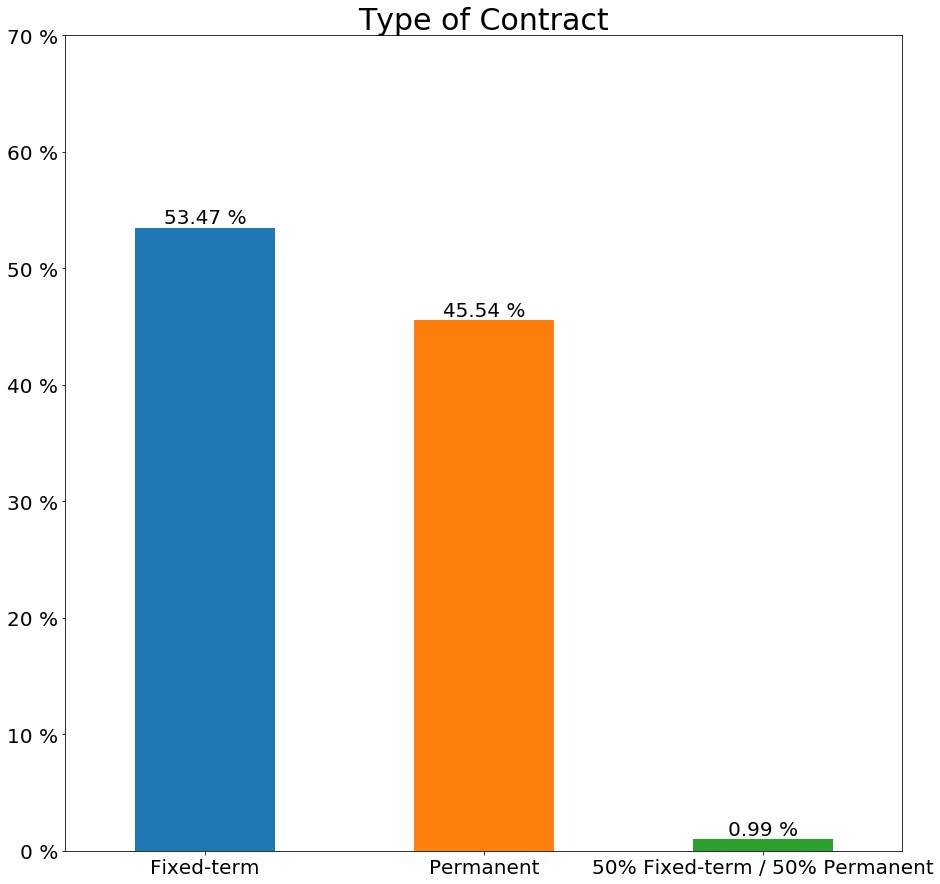

In [34]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Type of Contract',fontsize= 30) # title of plot

perc_to_contract=df['What type of contract do you have?'].value_counts()/df['What type of contract do you have?'].value_counts().sum()*100.
print(perc_to_contract)
perc_to_contract.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_age = []
for i in range(0,71,10):
    labels_age.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/contract.png', bbox_inches='tight')

What is your age?  What type of contract do you have?
35 - 44            50% Fixed-term / 50% Permanent         0.990099
65 or older        Permanent                              0.990099
Less then 25       Fixed-term                             0.990099
55 - 64            Permanent                              2.970297
45 - 54            Fixed-term                             3.960396
25 - 34            Permanent                              6.930693
45 - 54            Permanent                              8.910891
35 - 44            Fixed-term                            11.881188
                   Permanent                             25.742574
25 - 34            Fixed-term                            36.633663
Name: What type of contract do you have?, dtype: float64


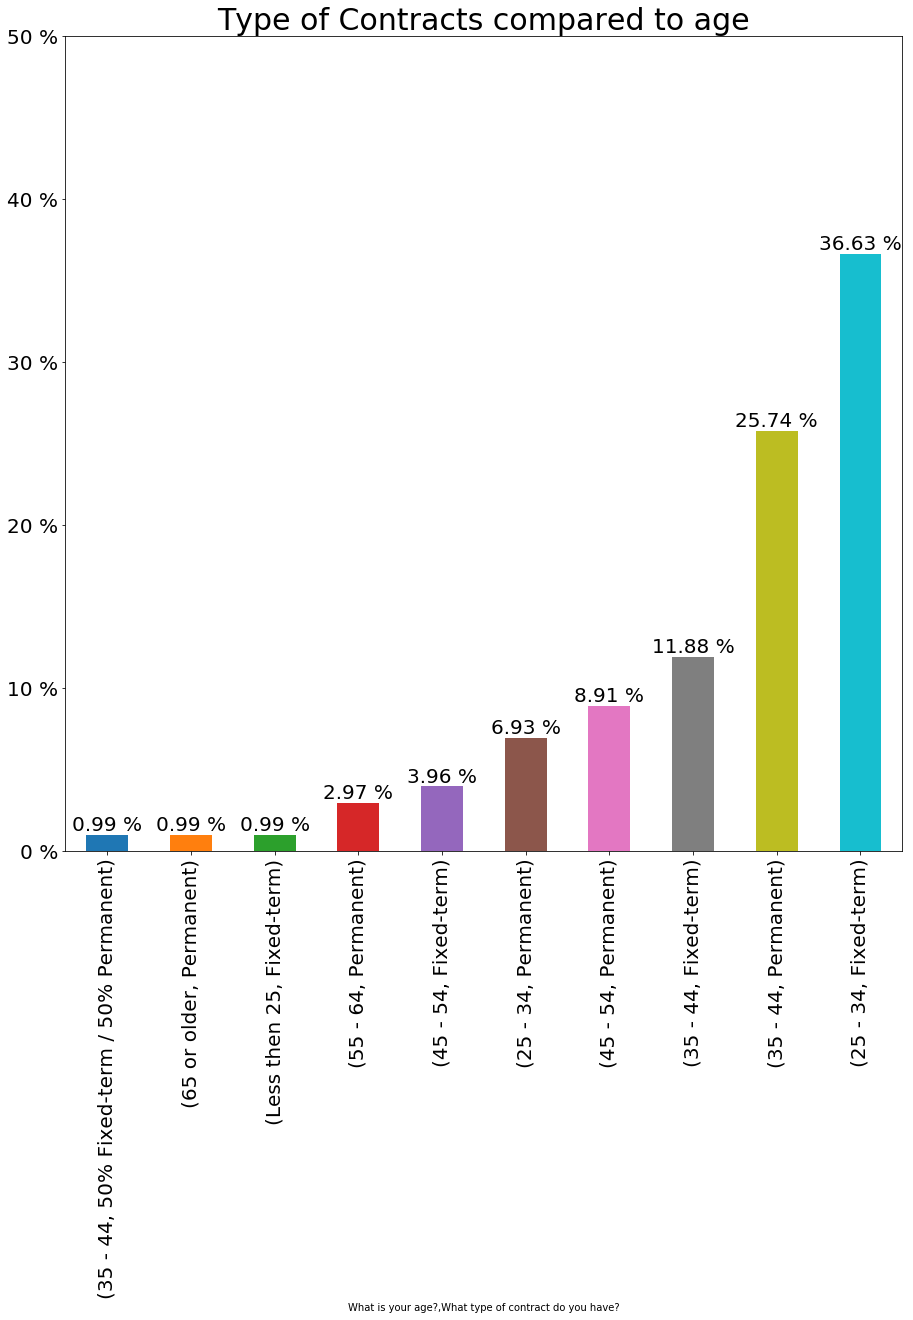

In [35]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Type of Contracts compared to age',fontsize= 30) # title of plot

perc_to_age_contract = df.groupby("What is your age?")['What type of contract do you have?'].value_counts().sort_values()/df.groupby("What is your age?")['What type of contract do you have?'].value_counts().sum()*100.
print(perc_to_age_contract)

perc_to_age_contract.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_age_contract = []
for i in range(0,51,10):
    labels_age_contract.append("{:} %".format(i))

ax.set_yticks(range(0,51,10))    
ax.set_yticklabels(labels=labels_age_contract)
fig.savefig('./2018/nordics/outputs/contract_age.png', bbox_inches='tight')

# Section 5. Training

RSEs have programming skills that is not necessarily shared within their field. Therefore, they can train other researchers to develop some best practices or learn how to program more efficiently. 69.31% of them participate to such training. They are not teaching directly to students but transferring skills is an important aspect of their job. 

## Training

### Have you ever trained researchers in computational techniques?

Yes    69.306931
No     30.693069
Name: Have you trained researchers?, dtype: float64


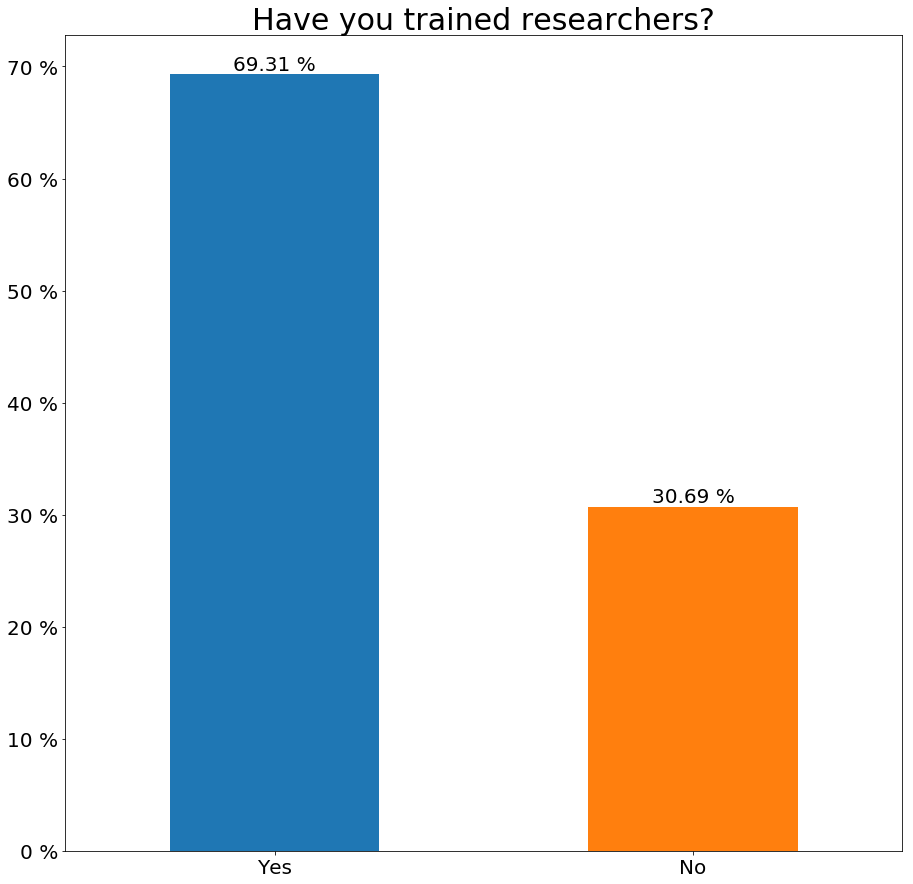

In [36]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Have you trained researchers?',fontsize= 30) # title of plot

perc_to_training=df['Have you trained researchers?'].value_counts()/df['Have you trained researchers?'].value_counts().sum()*100.
print(perc_to_training)
perc_to_training.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_training = []
for i in range(0,71,10):
    labels_training.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/training.png', bbox_inches='tight')

# Section 6. Publications

RSEs is an hybrid role between a researcher and a software developer. We investigated both of these aspects concerning publication and dissemination of their work, one on the traditional aspect of it (publications and conference) and on the more software aspect (open source and DOI).
One essential aspect of career in academia is the publications and the conferences to gain recognition. However, the role of RSE being less about writing articles than creating the infrastructure and the software for the article to exist, there is some fear that they will fail to have recognition through the papers and conferences.
Our results support this idea, while for 91% of the participants, their software is used in published researches they are only 67% (among them) who are acknowledged in the publication. Here we miss some information on whether they were cited in an acknowlegement section or added in the list of authors.


One important development practice is how the code is distributed and if the RSEs are releasing their work under open licence.
We asked the participants if they have ever released their work under open source licence and 68% of them replied by the affirmative. 

## Academic publications

### Has your code contributed to publication(s)

Yes      91.262136
No        4.854369
Maybe     3.883495
Name: Has your code contributed to publication(s)?, dtype: float64


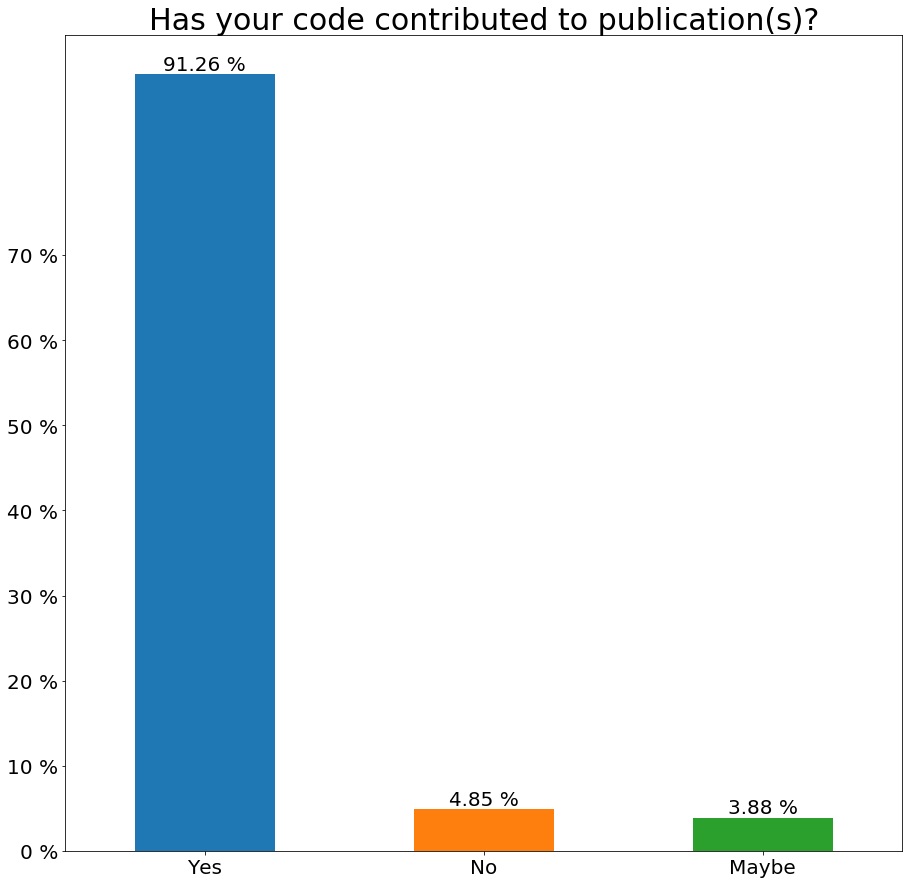

In [37]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Has your code contributed to publication(s)?',fontsize= 30) # title of plot

perc_to_publication=df['Has your code contributed to publication(s)?'].value_counts()/df['Has your code contributed to publication(s)?'].value_counts().sum()*100.
print(perc_to_publication)
perc_to_publication.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_publication = []
for i in range(0,71,10):
    labels_publication.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/publication.png', bbox_inches='tight')

## If your code has contributed to publication(s), were you acknowledged?

Yes      67.021277
Maybe    19.148936
No       13.829787
Name: If your code has contributed to publication(s), were you acknowledged?, dtype: float64


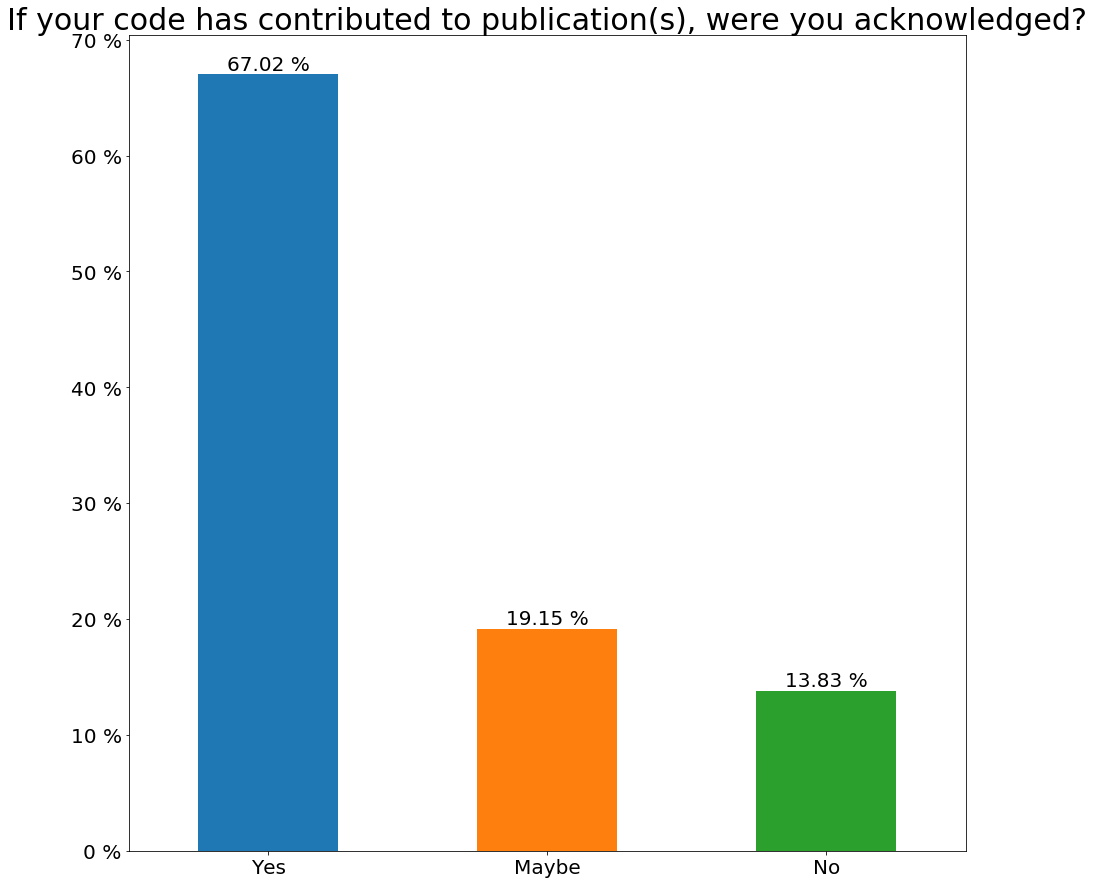

In [38]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('If your code has contributed to publication(s), were you acknowledged?',fontsize= 30) # title of plot

perc_to_ack=df['If your code has contributed to publication(s), were you acknowledged?'].value_counts()/df['If your code has contributed to publication(s), were you acknowledged?'].value_counts().sum()*100.
print(perc_to_ack)
perc_to_ack.plot.bar(fontsize=20, ax = ax, rot = 0)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_ack = []
for i in range(0,71,10):
    labels_ack.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/acknowledgement.png', bbox_inches='tight')

## Open source

### Have you ever released your software under an open-source licence?

Majority of my code is open source                   39.393939
All my code is open source                           39.393939
Minority of my code is open source                   11.111111
None of my code is open source                        9.090909
Current position: none, Previous work most of it.     1.010101
Name: If you develop software, is it open source?, dtype: float64


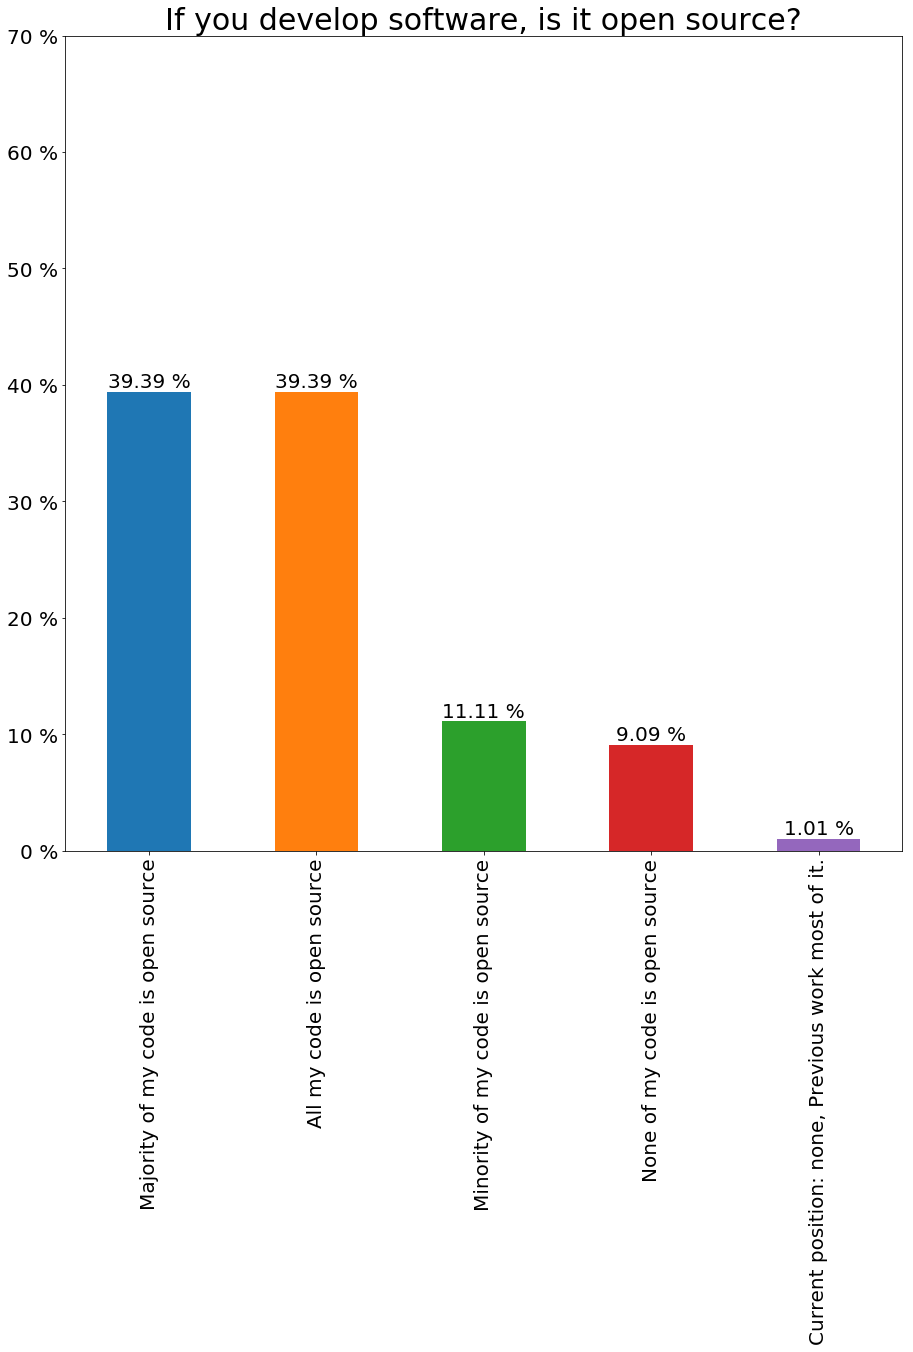

In [39]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('If you develop software, is it open source?',fontsize= 30) # title of plot

perc_to_open=df['If you develop software, is it open source?'].value_counts()/df['If you develop software, is it open source?'].value_counts().sum()*100.
print(perc_to_open)
perc_to_open.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_open = []
for i in range(0,71,10):
    labels_open.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/open_source.png', bbox_inches='tight')

# Section 8. Technical details


On technical details we wanted to know which of the programming languages are mostly used by the RSEs. Python, Unix Bash Shell Scripts and C/C++ are clearly the most used language with 22.47%, 16.29% and 14.89%. The rests of the languages that are higher than 5% are Matlab (8.14%), FORTRAN (7.86%), R (7.58%),  Javascript (5.61%) and SQL (5.33%).
About which Operating System used by RSEs, about half of Nordic RSEs are using GNU/Linux (52.17%), while Windows and OS X have less users (21.12% and 26.09%).

### What Operating System do you prefer to use at work?

Linux      84
macOS      42
Windows    34
illumos     1
dtype: int64
Linux      52.173913
macOS      26.086957
Windows    21.118012
illumos     0.621118
dtype: float64


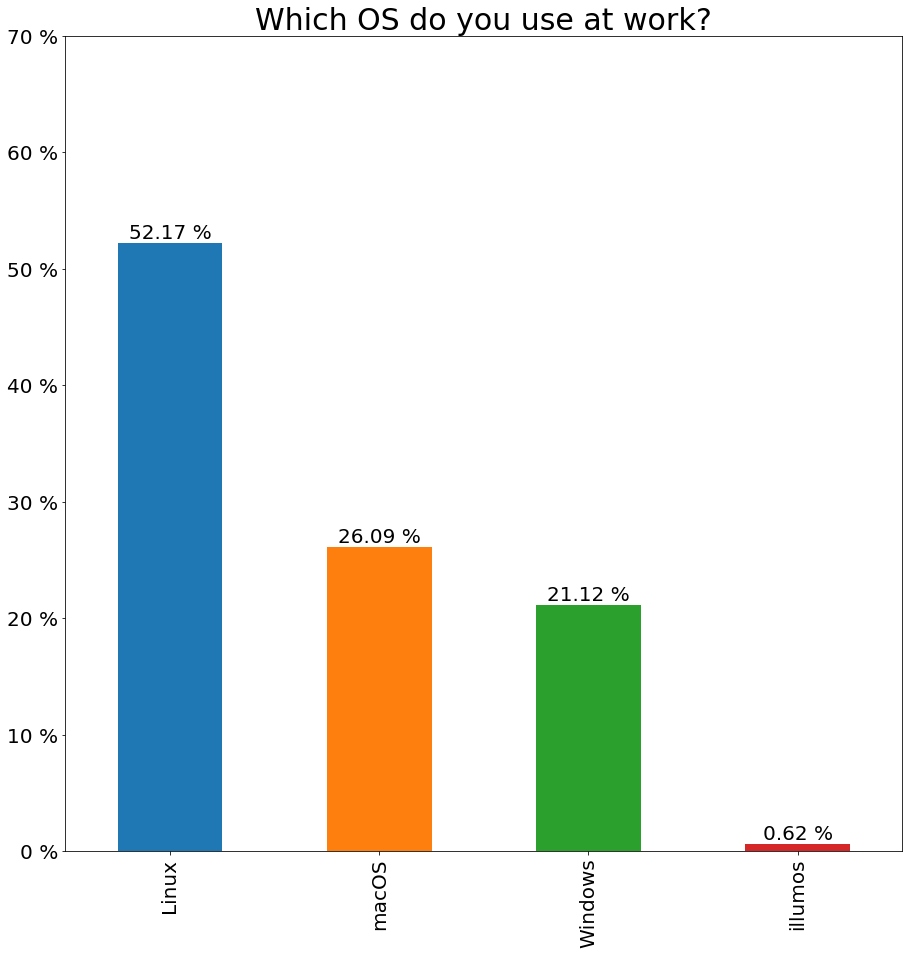

In [40]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Which OS do you use at work?',fontsize= 30) # title of plot

df_work = df['Which OS do you use at work?']
os_to_count = df_work.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()
print(os_to_count)
perc_to_os=os_to_count/os_to_count.values.sum()*100
print(perc_to_os)

perc_to_os.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_os = []
for i in range(0,71,10):
    labels_os.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/os.png', bbox_inches='tight')

### What programming languages do you use at work? (Select as many as apply)

In [41]:
df_work = df['Which languages do you use?']
language_to_count = df_work.str.split(';', expand=True).stack().str.strip().reset_index(level=1, drop=True).value_counts()
print(language_to_count)
perc_to_language=language_to_count/language_to_count.values.sum()*100
print(perc_to_language)


perc_to_language = perc_to_language[perc_to_language>5]

Python                                    80
Unix shell scripts                        58
C/C++                                     53
Matlab                                    29
Fortran                                   28
R                                         27
JavaScript                                20
SQL                                       19
Java                                      15
Julia                                      3
Scala                                      3
Scala, Rust                                1
Sage                                       1
Mathematica, Perl, Awk                     1
Perl                                       1
Stan                                       1
C#, Wolfram Mathematica                    1
Cython                                     1
C#                                         1
Go                                         1
Swift                                      1
Standard ML                                1
Glsl, cuda

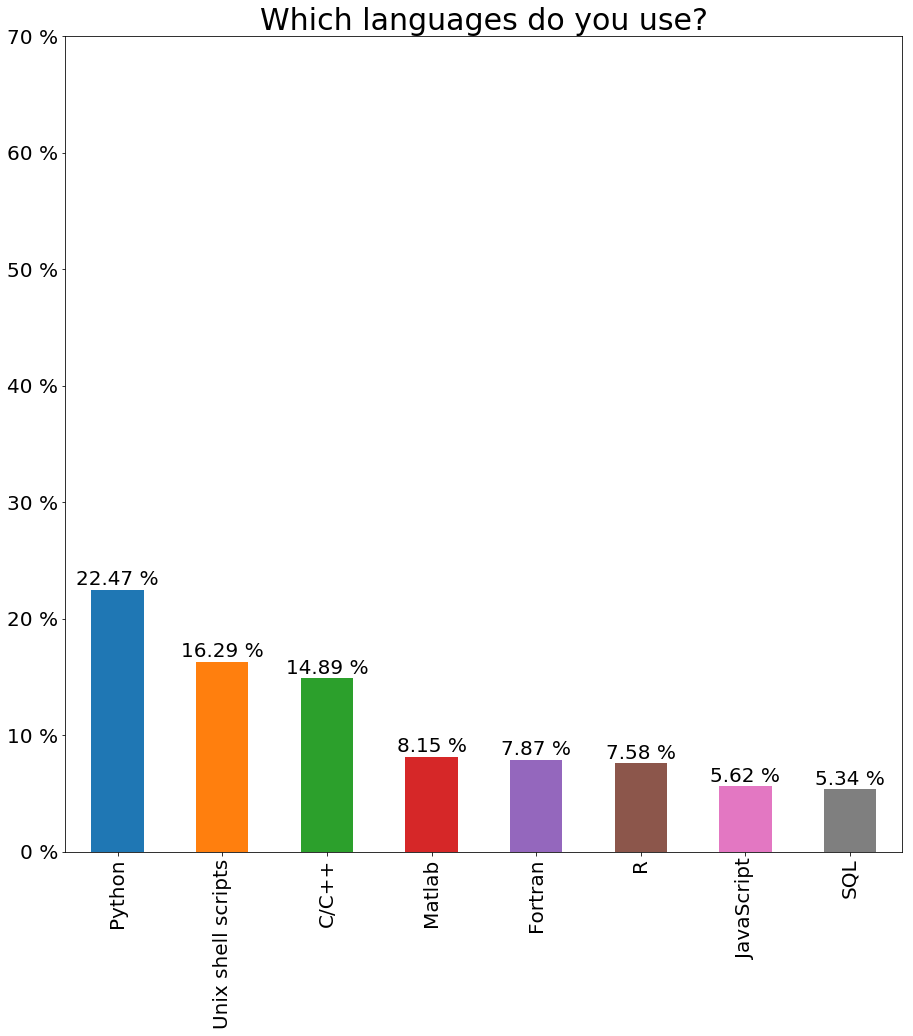

In [42]:
fig     = plt.figure(figsize=[15,15])
ax      = fig.add_subplot(111)
ax.set_title('Which languages do you use?',fontsize= 30) # title of plot

perc_to_language.plot.bar(fontsize=20, ax = ax, rot = 90)
# Add values on top of bars
for p in ax.patches:
    ax.annotate("{:0.2f} %".format(p.get_height()),(p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=20)
labels_language = []
for i in range(0,71,10):
    labels_language.append("{:} %".format(i))

ax.set_yticks(range(0,71,10))    
ax.set_yticklabels(labels=labels_age)
fig.savefig('./2018/nordics/outputs/language.png', bbox_inches='tight')